In [1]:
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
%matplotlib inline

In [3]:
from astropy.io import fits, ascii

In [4]:
from astropy.table import Table

In [5]:
f=fits.open('/users/caganze/desktop/DESY3_LTcatalog.fits')

In [6]:
t=Table(f[1].data).to_pandas()

In [7]:
import wisps.simulations as wispsim

In [8]:
from matplotlib.ticker import MultipleLocator

In [9]:
%matplotlib inline

In [10]:
t.columns

Index(['COADD_OBJECT_ID', 'RA', 'DEC', 'SPT_PHOT', 'NBANDS', 'XI2_CLASSIF',
       'DISTANCE_AVG', 'DISTANCE_Z', 'HPIX_512', 'PECULIAR', 'PSF_MAG_I',
       'PSF_MAGERR_I', 'PSF_MAG_Z', 'PSF_MAGERR_Z', 'AUTO_MAG_Y',
       'AUTO_MAGERR_Y', 'JAPERMAG3', 'JAPERMAG3ERR', 'HAPERMAG3',
       'HAPERMAG3ERR', 'KSAPERMAG3', 'KSAPERMAG3ERR', 'W1MPRO', 'W1SIGMPRO',
       'W2MPRO', 'W2SIGMPRO'],
      dtype='object')

In [11]:
#t['W2MPRO'].replace(-9999., np.nan).dropna()

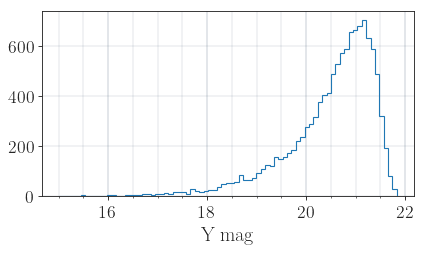

In [12]:
p=plt.hist(t['AUTO_MAG_Y'].replace(-9999., np.nan).dropna(), bins='auto', histtype='step')
plt.xlabel('Y mag')
ml = MultipleLocator(.5)
plt.gca().xaxis.set_minor_locator(ml)
plt.grid(which='both')
plt.show()

In [13]:
import splat.empirical as spe

In [14]:
spe.SPT_ABSMAG_RELATIONS['dupuy2012']['filters']['MKO_Y']#['coeff']

{'fitunc': 0.4,
 'range': [16.0, 39.0],
 'coeff': [-2.52638e-06,
  0.000285027,
  -0.0126151,
  0.279438,
  -3.26895,
  19.5444,
  -35.156]}

In [15]:
coeffs=spe.SPT_ABSMAG_RELATIONS['dupuy2012']['filters']['MKO_Y']['coeff']

In [16]:
import splat
import splat.empirical as spe

In [17]:
bright=18.
faint= 21.

In [18]:
spts=[]
max_dist=[]
min_dist=[]
nbr=[]
for spt, grp in t.groupby('SPT_PHOT'):
    #print (spt()
    spts.append(spt+10.)
    
    sptr=np.nanmean(np.random.normal(spt, 0.29, 1000))
    absmag=np.polyval(coeffs, sptr)
    dmax=(10.**(-(absmag-faint)/5. + 1.))
    dmin=(10.**(-(absmag-bright)/5. + 1.))
    
    print (absmag, dmax, dmin)

    max_dist.append(dmax)
    min_dist.append(dmin)
    nbr.append(len(grp))

12.657973352040408 466.02083059965213 117.05914011840905
12.947994544177774 407.756686237186 102.42384875164964
13.305117409534759 345.92067370480953 86.89134466577637
13.728438357247889 284.6507474561908 71.50103502542656
14.180672283962231 231.1349089860026 58.05846417301419
14.63376632799865 187.606004563393 47.12449773325114
15.025997655360733 156.6031411601733 39.33693054120189
15.339081772715964 135.57625879632144 34.05521649053113
15.55209449608087 122.90826858394618 30.873161217634973
15.648746900903916 117.5575752802569 29.529127826764324
15.638396934806671 118.11923158599699 29.670209512120376
15.549455949217247 123.05770466809514 30.91069786485012
15.427143474236154 130.188104891136 32.70177342199904
15.326781899409717 136.34638257982655 34.24866283876806
15.322312511040352 136.62730371486415 34.319227037510565
15.478417897981117 127.15001636372268 31.938640087025604
15.863678403888564 106.47908714162047 26.746337423056257
16.52945446025639 78.36264887846063 19.6838074454954

In [19]:
area=2400*(u.deg**2).to(u.radian**2)
sold=(np.sin(np.sqrt(area)))**2.0
vols=sold*(np.array(max_dist)**3.-np.array(min_dist)**3.)

In [20]:
lf=wisps.LUMINOSITY_FUCTION

In [21]:
spts=np.array(spts)

In [22]:
mask=np.logical_and(spts>=20., spts<=37.)

In [23]:
mask2=np.logical_and(lf.spts.values>=20., lf.spts.values<=37.)

In [24]:
%matplotlib inline

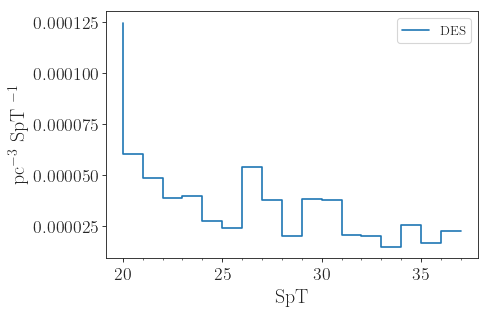

In [25]:
fig, ax=plt.subplots(figsize=(6, 4))
plt.step(spts[mask], (nbr/vols)[mask], label='DES')
#plt.scatter(lf.spts[mask2], lf.lsfim[mask2], marker='.', label='Simulated', c='orange')
ml = MultipleLocator(1.)
plt.gca().xaxis.set_minor_locator(ml)
#plt.yscale('log')
plt.xlabel('SpT')
plt.ylabel(r'pc$^{-3}$ SpT $^{-1}$')
plt.legend(fontsize=12)
plt.show()

In [26]:
deslf=pd.DataFrame()

In [27]:
deslf['spts']=spts
deslf['lf']=(nbr/vols)

In [28]:
deslf.to_pickle(wisps.OUTPUT_FILES+'/des_luminosity_function.pkl')